# YoloV2 - detection de chiffres avec le MNIST

Notebook de correction du TP.

## Génération des datasets

In [1]:
import os

PATH_DATASETS = "datasets/"
PATH_MNIST = os.path.join(PATH_DATASETS, "source")
PATH_TRAIN_SET = os.path.join(PATH_DATASETS, "train_set")
PATH_VAL_SET = os.path.join(PATH_DATASETS, "validation_set")

if not os.path.exists(PATH_DATASETS):
    os.mkdir(PATH_DATASETS)

In [2]:
from utils.generate_dataset import generate_dataset
from torchvision.datasets.mnist import MNIST

print("Generating train set...")
generate_dataset(
    source_dataset=MNIST(PATH_MNIST, train=True, download=True),
    path_dataset=PATH_TRAIN_SET,
    sample_count=5000,
    image_width=512,
    image_height=512,
    min_objects_per_image=0,
    max_objects_per_image=20,
    noise_strength=0
)

print("Generating test set...")
generate_dataset(
    source_dataset=MNIST(PATH_MNIST, train=False, download=True),
    path_dataset=PATH_VAL_SET,
    sample_count=500,
    image_width=512,
    image_height=512,
    min_objects_per_image=0,
    max_objects_per_image=20,
    noise_strength=0
)

print("Done!")

Generating train set...


100%|██████████| 5000/5000 [01:12<00:00, 69.05it/s]


Generating test set...


100%|██████████| 500/500 [00:07<00:00, 71.38it/s]

Done!


### Visualisation des datasets

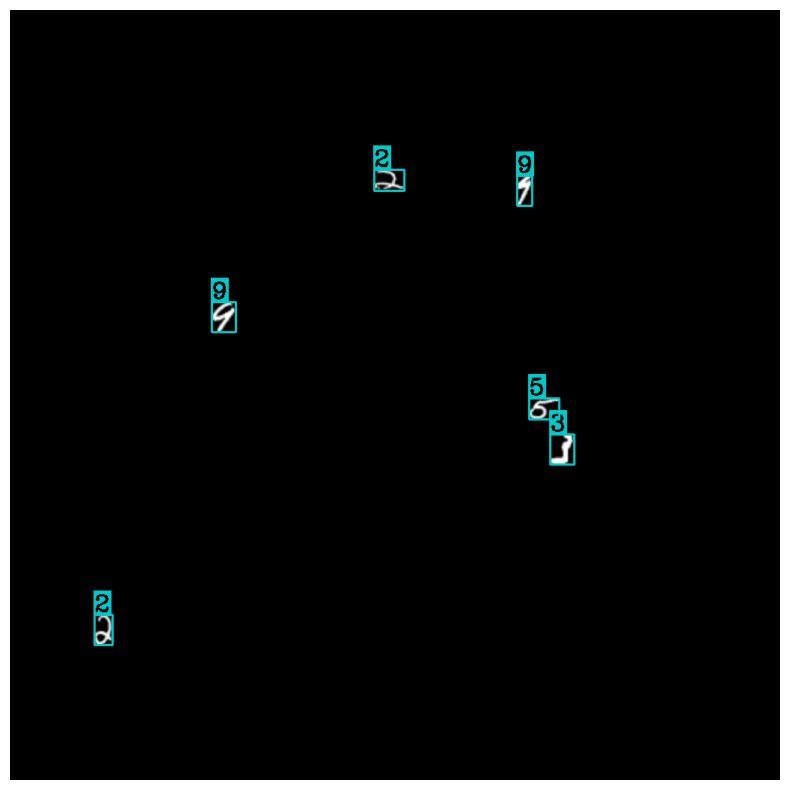

In [3]:
from utils.display_boxes import display_random_dataset_samples

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [15, 10]

images = display_random_dataset_samples(
    path_dataset=PATH_TRAIN_SET,
    sample_count=1
)

for image in images:
    plt.imshow(image)
    plt.axis("off")
    plt.show()

## Entraînement

In [4]:
from torchvision.models.mobilenetv2 import mobilenet_v2, MobileNet_V2_Weights
from torch.utils.data import DataLoader
from tqdm import tqdm
import torch.optim as optim
import torch
import torchvision.transforms as transforms
from torch import Tensor, nn
import numpy as np

from yolo.dataset import YoloDataset, collate_fn
from yolo.metrics import CocoEvaluator
from yolo.post_processor import non_maximum_suppression, filter_by_score


if torch.cuda.is_available():
    DEVICE = torch.device("cuda:0")
else:
    DEVICE = torch.device("cpu")

### Fonction d'activation

Le format du tenseur `encoded_boxes` avant l'activation:
- `x[..., 0] = x` : position x du centre de la boîte par rapport a sa cellule.
- `x[..., 1] = y` : position y du centre de la boîte par rapport a sa cellule.
- `x[..., 2] = w` : largeur de la boîte par rapport a son prior.
- `x[..., 3] = h` : hauteur de la boîte par rapport a son prior.
- `x[..., 4] = L` : score d'objectivité (probabilité que la boîte contienne un objet, logit pré-activation).
- `x[..., 5:] = Lc` : probabilités conditionelle des classes (logit pré-activation).

Le format du tenseur de sortie:
- `y[..., 0] = x` : position x du centre de la boîte par rapport a la feature map.
- `y[..., 1] = y` : position y du centre de la boîte par rapport a la feature map.
- `y[..., 2] = w` : largeur de la boîte par rapport a la feature map.
- `y[..., 3] = h` : hauteur de la boîte par rapport a la feature map.
- `y[..., 4] = P` : score d'objectivité.
- `y[..., 5:] = C` : probabilités conditionelle des classes.

In [5]:
def decode_boxes(
    encoded_boxes: Tensor,
    priors: Tensor,
    input_size: tuple[int, int]
) -> Tensor:
    """Decode the output bounding boxes.

    Args:
        encoded_boxes (Tensor): Encoded bounding boxes.
        priors (Tensor): Priors of shape (P x 2).
        input_size (tuple[int, int]): Shape of the input image.

    Returns:
        Tensor: Decoded bounding boxes.
    """
    grid_h, grid_w = encoded_boxes.shape[1:3]
    scale_h, scale_w = input_size[0] / grid_h, input_size[1] / grid_w

    # The predicted coordinates are local to the cell of the prediction, meaning it
    # is a value between 0 and 1, positioning the center of the box within that
    # cell. The goal of the activation function is to get the coordinates of the box
    # in relative to the grid (i.e. x in [0 WG[ and y in [0 HG[). To do this, first
    # we create a tensor in which each cell contains its own coordinates within the
    # grid (shape: (1 x HG x WG x 1 x 2)).
    cell_w = torch.arange(0, grid_w, dtype=torch.float32).to(encoded_boxes.device)
    cell_h = torch.arange(0, grid_h, dtype=torch.float32).to(encoded_boxes.device)
    cell_grid = torch.stack(torch.meshgrid(cell_w, cell_h, indexing="ij"))
    cell_grid = torch.swapaxes(cell_grid, 0, -1)
    cell_grid = torch.reshape(cell_grid, shape=(1, grid_h, grid_w, 1, 2))

    # Then, we add the coordinates of the cell to the coordinates of the box after
    # applying the sigmoid function (shape: (BS x HG x WG x P x 2)).
    predicted_xy = encoded_boxes[..., :2]
    predicted_xy = torch.sigmoid(predicted_xy)
    predicted_xy = cell_grid + predicted_xy

    # The predicted dimension of the box is relative to the associated prior. The
    # activation function used here is the exponential function, meaning that a
    # predicted size of 0 pre-activation will give the size of the prior (shape:
    # (BS x HG x WG x P x 2)).
    predicted_wh = encoded_boxes[..., 2:4]
    predicted_wh = torch.exp(predicted_wh)
    predicted_wh = priors * predicted_wh

    # Since the priors are relative to the input image size, we have to rescale the
    # boxes to the grid.
    predicted_wh[..., 0] /= scale_w
    predicted_wh[..., 1] /= scale_h

    # The predicted objectness is merely obtained by applying the sigmoid function
    # to the logit. This probability indicates whether the box actually contains an
    # object. The loss function used by YOLOv2 will make this value quantify the
    # quality of the box (shape: (BS x HG x WG x P x 1)).
    predicted_objectness = encoded_boxes[..., 4]
    predicted_objectness = torch.sigmoid(predicted_objectness)
    predicted_objectness = predicted_objectness.unsqueeze(dim=-1)

    # Finally, the conditional probability vector is obtained by applying the
    # softmax function (shape: (BS x HG x WG x P x C])).
    predicted_probabilities = encoded_boxes[..., 5:]
    predicted_probabilities = torch.softmax(predicted_probabilities, dim=-1)

    # The output tensor is then assembled by concatenating the previously computed
    # tensors (shape: (BS x HG x WG x P x (5+C))).
    decoded_boxes = torch.cat([
        predicted_xy,
        predicted_wh,
        predicted_objectness,
        predicted_probabilities
    ], axis=-1)

    return decoded_boxes


### Definition de la tête de detection

In [6]:
class YoloDetectionHead(nn.Module):
    """Yolo detection head."""

    def __init__(
        self,
        in_channels: int,
        priors: Tensor | np.ndarray,
        num_classes: int
    ) -> None:
        """Initialize the detection head.

        Args:
            in_channels (int): Depth of the input feature map.
            priors (Tensor | np.ndarray): Pre-computed priors.
            num_classes (int): Number of output class.
        """
        super().__init__()

        self.num_classes = num_classes
        self.prior_count = priors.shape[0]

        if isinstance(priors, np.ndarray):
            priors = torch.from_numpy(priors)

        self.register_buffer("priors", priors)

        self.convolution_head = nn.Conv2d(
            in_channels=in_channels,
            out_channels=self.prior_count * (5 + num_classes),
            kernel_size=1
        )

    def forward(
        self,
        feature_maps: Tensor,
        input_size: tuple[int, int]
    ) -> Tensor:
        """Compute bounding boxes based on the given feature map.

        Args:
            feature_maps (Tensor): Feature extractor output tensor.
            input_size (tuple[int, int]): Input sizes of each image of the batch.

        Returns:
            Tensor: Decoded bounding boxes.
        """
        encoded_boxes = self.convolution_head(feature_maps)

        # The decode function expects to receive a BS x HG x WG x P x (5+C) tensor.
        # Since torch uses a channels first format, we have a BS x [B*(5+C)] x HG x WG
        # tensor at this step, so we have to move the axes around. First, we switch from
        # channels first to channels last and then split the channels into priors x
        # classes.
        encoded_boxes_reshaped = torch.moveaxis(encoded_boxes, 1, -1)
        encoded_boxes_reshaped = torch.reshape(encoded_boxes_reshaped, shape=(
            *encoded_boxes_reshaped.shape[:-1], self.prior_count, 5 + self.num_classes
        ))

        decoded_boxes = decode_boxes(encoded_boxes_reshaped, self.priors, input_size)

        return decoded_boxes

### Fonction de coût

Formats des tenseurs de sorties et GT (shape: BS x HG x WG x P x (5+C)):
- `y[..., 0] = x` : position x du centre de la boîte par rapport a la feature map.
- `y[..., 1] = y` : position y du centre de la boîte par rapport a la feature map.
- `y[..., 2] = w` : largeur de la boîte par rapport a la feature map.
- `y[..., 3] = h` : hauteur de la boîte par rapport a la feature map.
- `y[..., 4] = P` : score d'objectivité.
- `y[..., 5:] = C` : probabilités conditionelle des classes.

Pour les GT, toutes les valeurs sont à 0 si il n'y pas de boîte dans la cellule.

In [7]:
def loss_yolo(predicted: Tensor, ground_truth: Tensor) -> Tensor:
    """Compute the Yolo loss.

    Args:
        predicted (Tensor): The predicted tensor.
        ground_truth (Tensor): The ground truth tensor.

    Returns:
        Tensor: The loss tensor.
    """
    # First, we split the predicted tensors to retrieve the coordinates and the
    # conditional probabilities.
    predicted_xy = predicted[..., :2]  # (BS x HG x WG x P x 2)
    predicted_wh = predicted[..., 2:4]  # (BS x HG x WG x P x 2)
    predicted_objectness = predicted[..., 4]  # (BS x HG x WG x B)
    predicted_probabilities = predicted[..., 5:]  # (BS x HG x WG x P x C)

    # Same for the ground truth tensors.
    true_xy = ground_truth[..., :2]  # (BS x HG x WG x P x 2)
    true_wh = ground_truth[..., 2:4]  # (BS x HG x WG x P x 2)
    true_objectness = ground_truth[..., 4]  # (BS x HG x WG x B)
    true_probabilities = ground_truth[..., 5:]  # (BS x HG x WG x P x C)

    # Position error: a simple square error between the predicted and ground truth
    # positions.
    diff_xy = torch.square(predicted_xy - true_xy)
    diff_xy = torch.sum(diff_xy, dim=-1)
    diff_xy = diff_xy * true_objectness

    # Dimension error: a square error between the square roots of the predicted and
    # ground truth dimensions.
    diff_wh = torch.square(torch.sqrt(predicted_wh) - torch.sqrt(true_wh))
    diff_wh = torch.sum(diff_wh, dim=-1)
    diff_wh = diff_wh * true_objectness

    # The following operations consists in determining the IOU between the predicted and
    # ground truth boxes. First, we compute the position of top-left and bottom-right
    # corners of the predicted boxes.
    predicted_x0_y0 = predicted_xy - predicted_wh / 2
    predicted_x1_y1 = predicted_xy + predicted_wh / 2

    # Same goes for the ground truth boxes.
    true_x0_y0 = true_xy - true_wh / 2
    true_x1_y1 = true_xy + true_wh / 2

    # Then we compute the coordinates of the intersection between the predicted and
    # ground truth boxes.
    intersection_x0_y0 = torch.maximum(predicted_x0_y0, true_x0_y0)
    intersection_x1_y1 = torch.minimum(predicted_x1_y1, true_x1_y1)

    # Using the coordinates, we can deduce the dimensions of the intersection.
    # If the intersection is empty, at least one of the dimension will be negative. By
    # setting it to zero, the intersection area will be zero.
    intersection_wh = intersection_x1_y1 - intersection_x0_y0
    intersection_wh = torch.clamp(intersection_wh, min=0)

    # Then, we compute the intersection area between the predicted and ground truth
    # boxes.
    intersection_area = intersection_wh[..., 0] * intersection_wh[..., 1]

    # To compute the IOU we also need to compute the union area.
    predicted_area = predicted_wh[..., 0] * predicted_wh[..., 1]
    true_area = true_wh[..., 0] * true_wh[..., 1]
    union_area = predicted_area + true_area - intersection_area

    # Finally, we compute the IOU between the predicted and ground truth boxes.
    iou_scores = intersection_area / union_area

    # Objectness error: a square error between the predicted objectness and the IOU
    # between the boxes. This means that the objectness will tend to quantify the
    # quality of the predicted box.
    diff_objectness = torch.square(predicted_objectness - iou_scores)
    diff_objectness = diff_objectness * true_objectness

    # No objectness error: if the predicted box does not contain an object, the
    # objectness should tend to zero.
    diff_no_object = torch.square(predicted_objectness)
    diff_no_object = diff_no_object * (1 - true_objectness)

    # Classification error: a square error between the predicted and ground truth
    # conditional probabilities. Note that any kind of classification loss can be used
    # such as the binary cross-entropy.
    diff_classification = torch.square(predicted_probabilities - true_probabilities)
    diff_classification = torch.sum(diff_classification, dim=-1)
    diff_classification = diff_classification * true_objectness

    # The total loss is the weighted sum of all the previously computed errors.
    diff = (
        5 * diff_xy +
        5 * diff_wh +
        diff_objectness +
        diff_no_object +
        diff_classification
    )

    diff = torch.sum(diff, dim=(1, 2, 3))
    loss = torch.mean(diff)

    return loss


### Definition du modèle

In [8]:
from yolo.detection_head import YoloDetectionHead
from yolo.ground_truth import YoloAnnotation, generate_ground_truth_tensors
from yolo.loss_fn import loss_yolo
from yolo.post_processor import DetectionResult, decode_boxes as box_tensor_to_box_list

class YoloDetector(nn.Module):
    """Yolo detector model."""

    def __init__(
        self,
        backbone: nn.Module,
        priors: np.ndarray,
        num_classes: int,
        feature_map_depth: int = 1280
    ) -> None:
        """Initialize the model.

        Args:
            backbone (nn.Module): Feature extractor.
            priors (np.ndarray): Model priors.
            num_classes (int): Number of output class.
            feature_map_depth (int): Depth of the feature extractor output.
        """
        super().__init__()

        self.priors = priors

        self.backbone = backbone
        self.detection_head = YoloDetectionHead(feature_map_depth, priors, num_classes)

    def forward(
        self,
        images: Tensor,
        targets: list[list[YoloAnnotation]] | None = None
    ) -> Tensor | list[DetectionResult]:
        """Run the detector.

        This function behavior differ between training and evaluation.
        - when training, the targets (ground truth) must be supplied, and the loss is
          directly returned.
        - when not training, the decoded bounding boxes are returned (the boxes are not
          filtered yet, so more post-processing such as NMS may be required).
        This is done this way since it is how it is done in the torchvision library.

        Args:
            images (Tensor): Input images (must be batched).
            targets (list[list[YoloAnnotation]], optional): Used in training mode, the
                ground truth values.

        Returns:
            Tensor | list[DetectionResult]: Either the loss over the batch in training
                mode, or the detected boxes.
        """
        input_size = images.shape[2:]
        batched_box_tensors = self.detection_head(self.backbone(images), input_size)

        if self.training:
            assert targets is not None, "Targets are required when training."

            ground_truth = generate_ground_truth_tensors(
                annotations=targets,
                priors=self.priors,
                input_size=input_size,
                grid_size=batched_box_tensors.shape[1:3],
                num_classes=self.detection_head.num_classes
            ).to(images.device)

            return loss_yolo(batched_box_tensors, ground_truth)

        return [
            box_tensor_to_box_list(box_tensor, input_size)
            for box_tensor in batched_box_tensors
        ]


### Chargement des datasets et calcul des priors

In [9]:
path_train_annotations = os.path.join(PATH_TRAIN_SET, "annotations.json")
path_train_images = os.path.join(PATH_TRAIN_SET, "images")

path_val_annotations = os.path.join(PATH_VAL_SET, "annotations.json")
path_val_images = os.path.join(PATH_VAL_SET, "images")

train_dataset = YoloDataset(path_train_annotations, path_train_images)
val_dataset = YoloDataset(path_val_annotations, path_val_images)

priors = train_dataset.get_priors(cluster_count=3)

print("Priors utilisés:")
print(priors)

Priors utilisés:
[[12.94792396 19.99994168]
 [ 6.51933702 20.        ]
 [18.3101176  19.56420654]]


### Création du modèle

On utilise le feature extractor de MobileNetV2, il a l'avantage d'être plutot léger. Sa feature map contient 1280 caractéristiques.

In [10]:
detector = YoloDetector(
    backbone=mobilenet_v2(
        weights=MobileNet_V2_Weights.DEFAULT,
        progress=True
    ).features,
    priors=priors,
    num_classes=10,
    feature_map_depth=1280  # Profondeur de la feature map du MobileNet
).to(DEVICE)

detector

YoloDetector(
  (backbone): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps

### Boucle de train et validation

Note: un modèle de type `YoloDetector` change de comportement entre le train et le test:
- Pendant le train, appeler le modèle en passant les GT retourne directement la loss.
- Pendant le test, le modèle retourne les boîtes décodées.

Les détections sont représentées sour la forme d'un dictionnaire
- `"boxes"`: les bounding boxes dans le format _xywh_
- `"scores"`: un vecteur des scores de chaque boîte
- `"labels"`: un vecteur des labels de chaque boîte

In [25]:
def train_step(
    detector: YoloDetector,
    data_loader: DataLoader,
    optimizer: optim.Optimizer,
    image_transforms: torch.nn.Module,
    device: torch.device
) -> float:
    """Run a single train epoch.

    Args:
        detector (YoloDetector): Yolo model.
        data_loader (DataLoader): Torch data loader.
        optimizer (Optimizer): Torch optimizer.
        image_transforms (nn.Module): Transforms applied to the image.
        device (torch.device): Model device.

    Returns:
        float: Average loss over the epoch.
    """
    detector.train()
    running_loss = 0

    for images, targets in tqdm(data_loader):
        optimizer.zero_grad()

        images = images.to(device)
        images = image_transforms(images)

        loss = detector(images, targets)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    return running_loss / len(data_loader)


def validation_step(
    detector: YoloDetector,
    data_loader: DataLoader,
    image_transforms: torch.nn.Module,
    device: torch.device,
    scheduler: optim.lr_scheduler.LRScheduler | None = None
) -> float:
    """Run a single validation step.

    Args:
        detector (YoloDetector): Yolo model.
        data_loader (DataLoader): Torch data loader.
        image_transforms (nn.Module): Transforms applied to the image.
        device (torch.device): Model device.
        scheduler (LRScheduler, optional): Learning scheduler

    Returns:
        float: mAP over the validation set.
    """
    detector.eval()

    # L'objet ci-dessous est un wrapper autour de la lib `pycocotools`. pycocotools est
    # une library qui n'est pas très pratique à utiliser, mais implemente les fonctions
    # pour le calcul de la mAP, ce wrapper permet d'eviter tout le boilerplate
    # necessaire.
    evaluator = CocoEvaluator()

    with torch.no_grad():
        for images, targets in tqdm(data_loader):
            images = images.to(device)
            images = image_transforms(images)

            detections = detector(images)

            for detection, target in zip(detections, targets):
                evaluator.add_detections(detection, target)

    metrics = evaluator.compute_metrics()

    if scheduler is not None:
        scheduler.step(metrics)

    return metrics



### Parametrage de l'entrainement

On utilise Adam comme optimizer, avec un scheduler pour réduire le learning rate lorsque la mAP n'augmente plus.

In [14]:
batch_size = 12  # A choisir en fonction de la GPU
learning_rate = 0.001
num_epochs = 10

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)
optimizer = optim.Adam(detector.parameters(), lr=learning_rate)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="max")

# Valeurs de normalisation utilisées par le MobileNet.
image_transforms = transforms.Normalize(
    mean=[0.485, 0.456, 0.406],
    std=[0.229, 0.224, 0.225]
)

best_checkpoint = None
best_map = 0

In [19]:
for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")

    loss = train_step(detector, train_loader, optimizer, image_transforms, DEVICE)
    metrics = validation_step(detector, val_loader, image_transforms, DEVICE, scheduler)

    print(f"Train loss over the epoch: {loss:.2f}")
    print(f"Validation mAP: {metrics:.2f}")

    if metrics > best_map:
        best_map = metrics
        torch.save(detector.state_dict(), "checkpoint.pth")

print("Training done!")

Epoch 1/10


100%|██████████| 42/42 [00:03<00:00, 13.21it/s]


Train loss over the epoch: 0.99
Validation mAP: 0.40
Epoch 2/10


100%|██████████| 42/42 [00:03<00:00, 10.91it/s]


Train loss over the epoch: 0.92
Validation mAP: 0.21
Epoch 3/10


100%|██████████| 42/42 [00:03<00:00, 12.90it/s]


Train loss over the epoch: 0.85
Validation mAP: 0.30
Epoch 4/10


100%|██████████| 42/42 [00:03<00:00, 12.34it/s]


Train loss over the epoch: 0.78
Validation mAP: 0.38
Epoch 5/10


100%|██████████| 42/42 [00:03<00:00, 12.79it/s]


Train loss over the epoch: 0.90
Validation mAP: 0.25
Epoch 6/10


100%|██████████| 42/42 [00:03<00:00, 12.49it/s]


Train loss over the epoch: 0.81
Validation mAP: 0.32
Epoch 7/10


100%|██████████| 42/42 [00:03<00:00, 13.21it/s]


Train loss over the epoch: 0.69
Validation mAP: 0.23
Epoch 8/10


100%|██████████| 42/42 [00:03<00:00, 10.97it/s]


Train loss over the epoch: 0.67
Validation mAP: 0.24
Epoch 9/10


100%|██████████| 42/42 [00:03<00:00, 12.52it/s]


Train loss over the epoch: 0.65
Validation mAP: 0.06
Epoch 10/10


100%|██████████| 42/42 [00:04<00:00, 10.50it/s]


Train loss over the epoch: 0.62
Validation mAP: 0.03
Training done!


### Visualisation des resultats

In [26]:
detector.load_state_dict(torch.load("checkpoint.pth"))
detector.eval()

metrics = validation_step(detector, val_loader, image_transforms, DEVICE, scheduler)
print(f"Validation mAP: {metrics:.2f}")

100%|██████████| 42/42 [00:03<00:00, 12.32it/s]


Validation mAP: 0.40


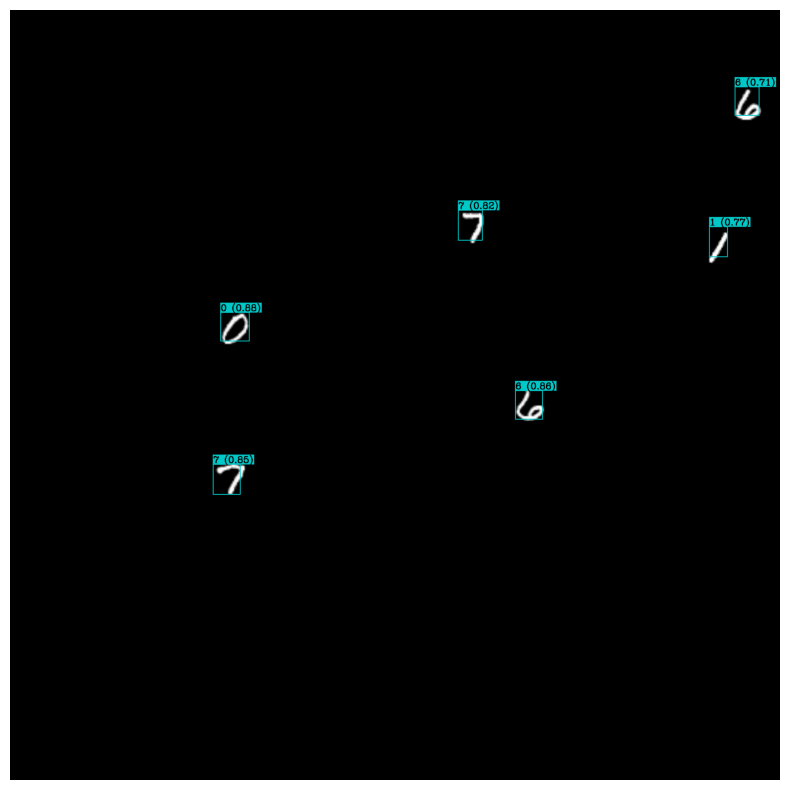

In [27]:
from utils.display_boxes import display_image_with_boxes
import random
import cv2

path_image = os.path.join(path_val_images, random.choice(os.listdir(path_val_images)))

image = cv2.imread(path_image)
image_torch = torch.from_numpy(image).to(torch.float32)
image_torch = torch.moveaxis(image_torch, -1, 0) / 255
image_torch = image_torch.unsqueeze(0)
image_torch = image_transforms(image_torch)
image_torch = image_torch.to(DEVICE)

with torch.no_grad():
    detector.eval()
    detections = detector(image_torch)[0]

detections = filter_by_score(detections, 0.3)
detections = non_maximum_suppression(detections)

image_with_detections = display_image_with_boxes(
    image,
    boxes=detections["boxes"],
    labels=detections["labels"],
    scores=detections["scores"],
    mode="xywh",
    display_labels=True,
    scaling_factor=5
)

plt.imshow(image_with_detections)
plt.axis("off")
plt.show()
